In [51]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-darkgrid'])

# Code Examples

#### Code 5.1

In [86]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [4]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1172.77draws/s]


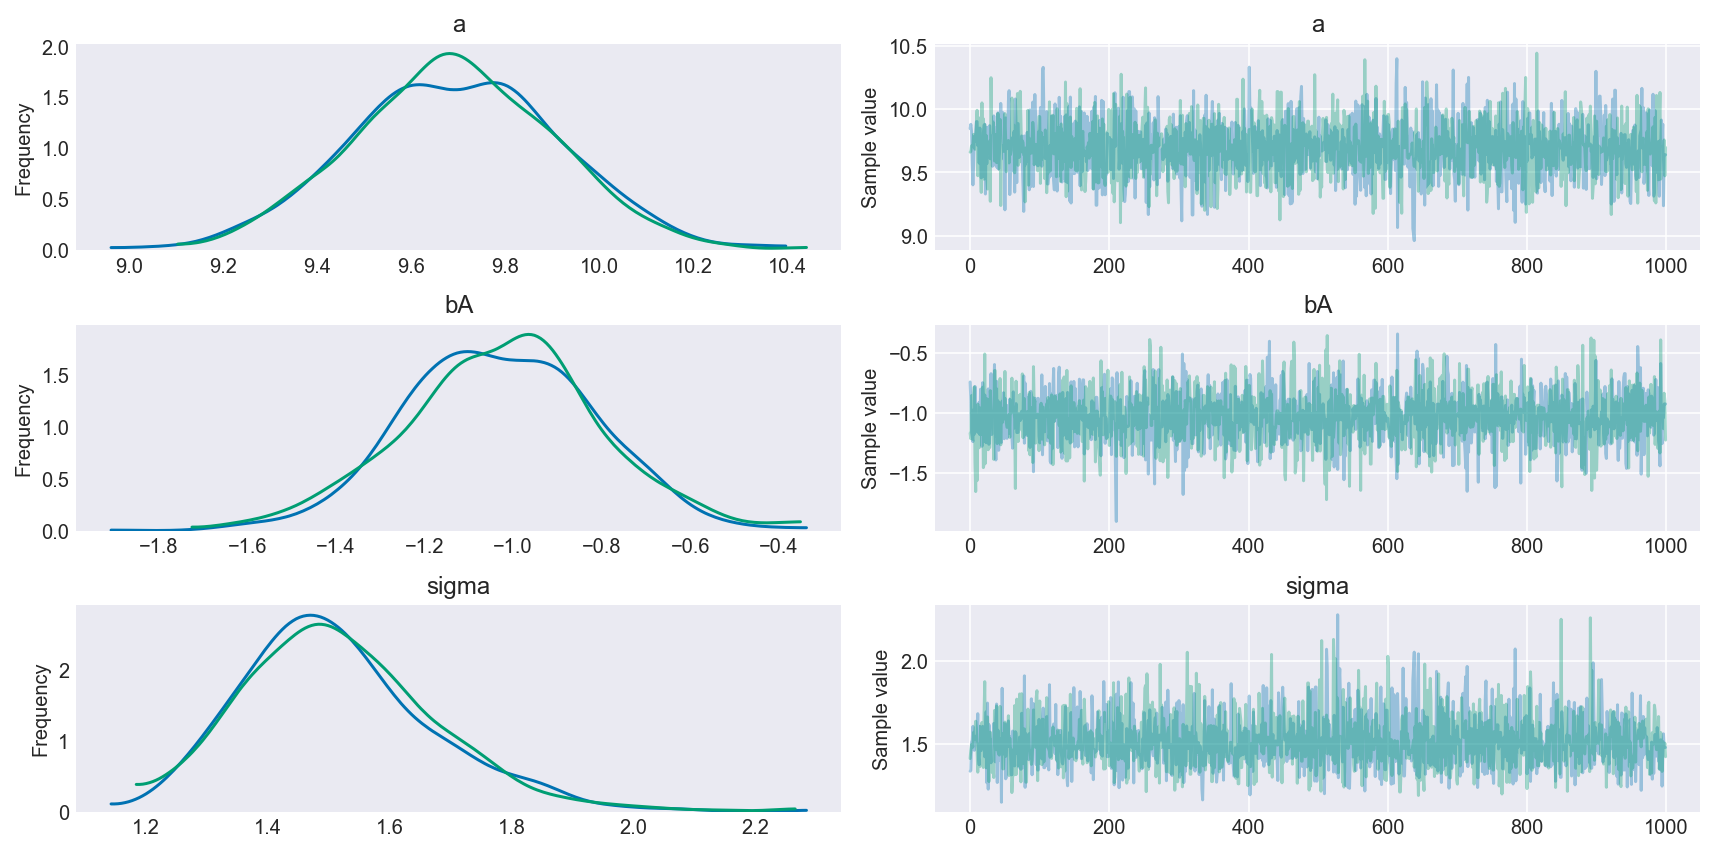

In [5]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

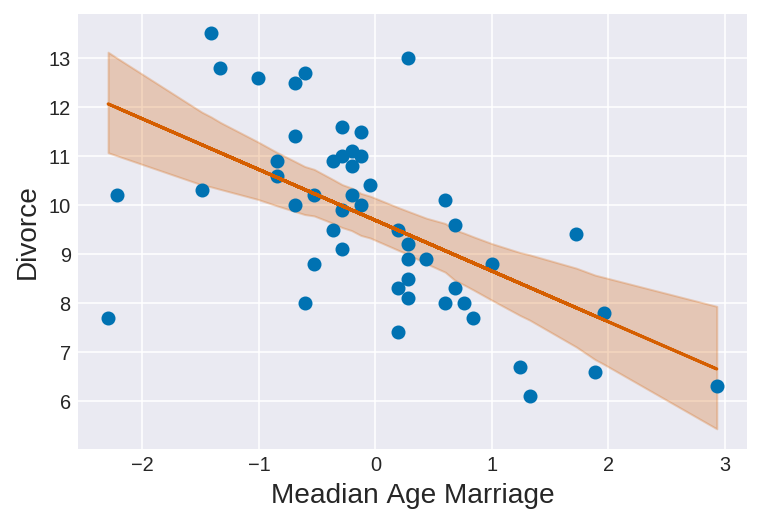

In [5]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [87]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [7]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bA, a]
100%|██████████| 2000/2000 [00:01<00:00, 1349.79it/s]


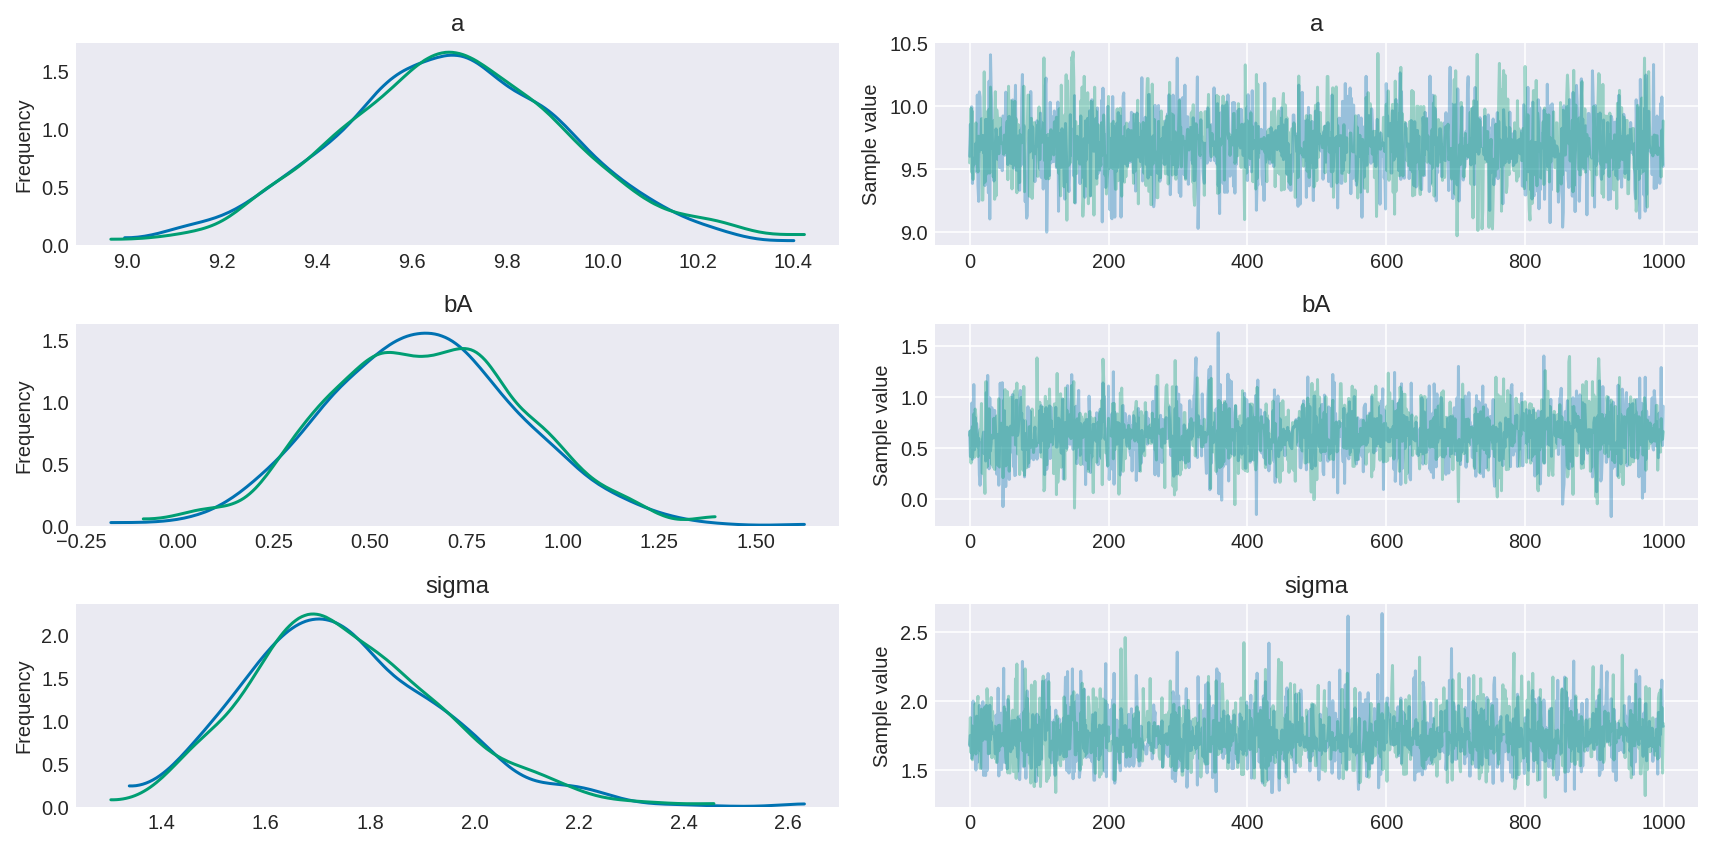

In [8]:
pm.traceplot(trace_5_2, varnames);

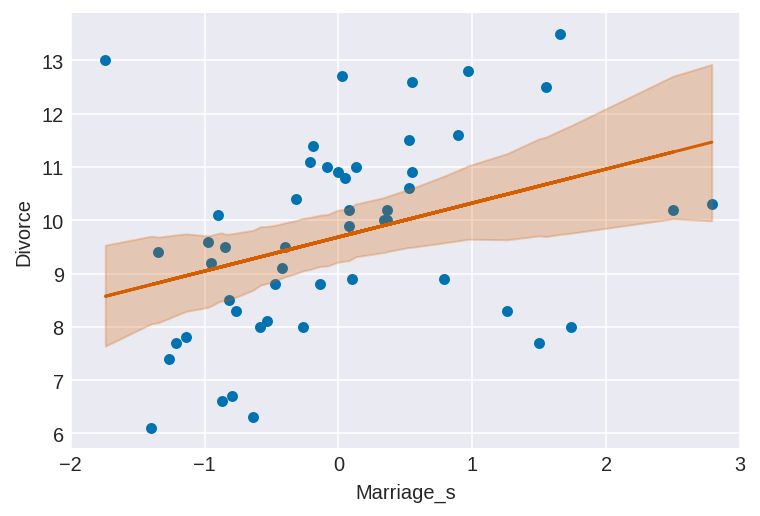

In [9]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx],
                 color='C2', alpha=0.25);

#### Code 5.4

In [10]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bA, a]
100%|██████████| 2000/2000 [00:02<00:00, 831.77it/s]


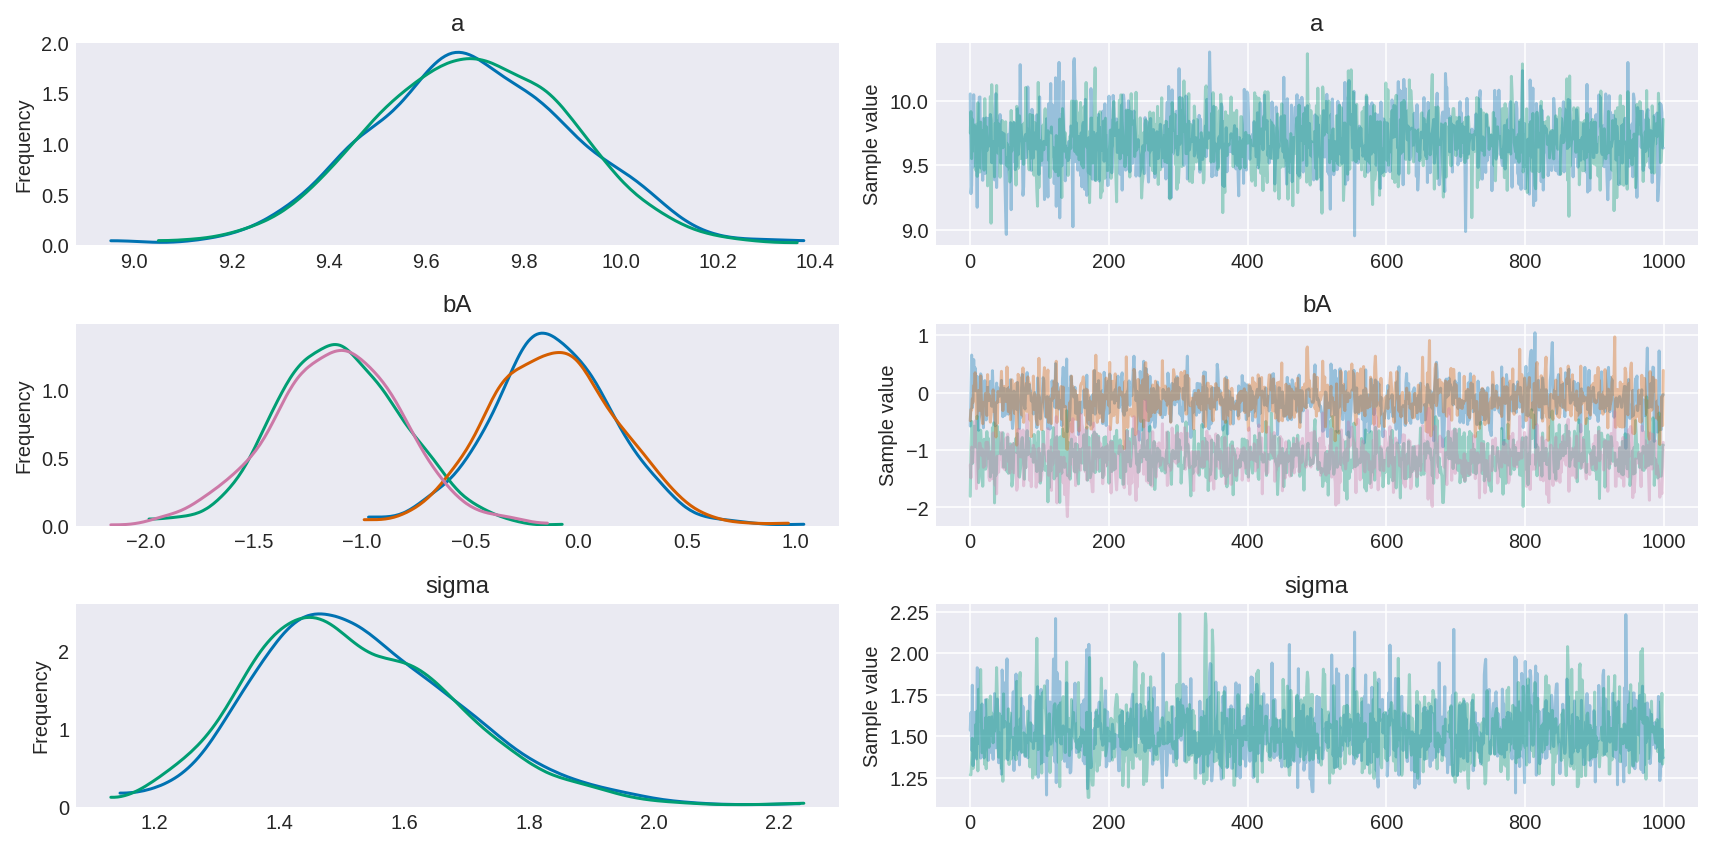

In [11]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [12]:
pm.summary(trace_5_3, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      9.690  0.208     0.005    9.371    10.028  1930.453  1.000
bA__0 -0.123  0.292     0.008   -0.558     0.364  1273.829  1.000
bA__1 -1.117  0.296     0.008   -1.540    -0.600  1244.420  1.000
sigma  1.527  0.167     0.004    1.259     1.768  1636.178  1.001

#### Code 5.5

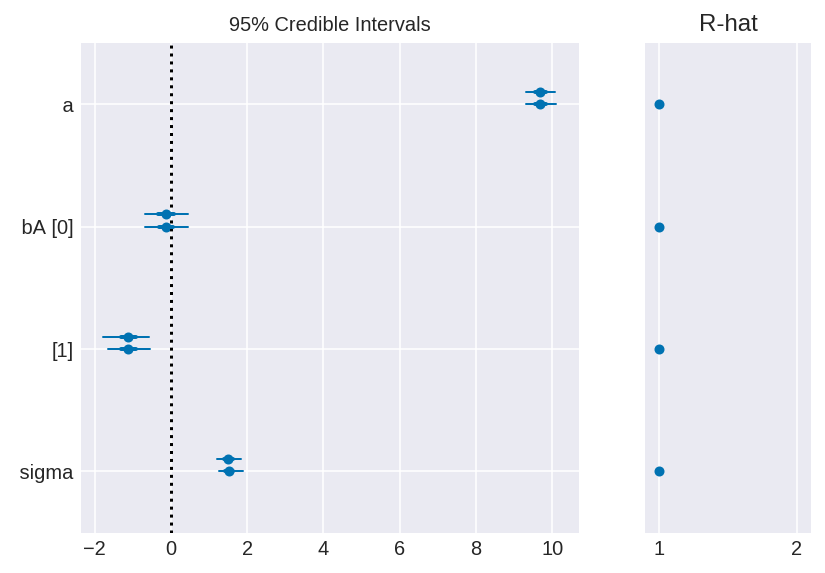

In [13]:
pm.forestplot(trace_5_3, varnames=varnames);

#### Code 5.6

In [14]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, b, a]
100%|██████████| 2000/2000 [00:02<00:00, 996.94it/s]


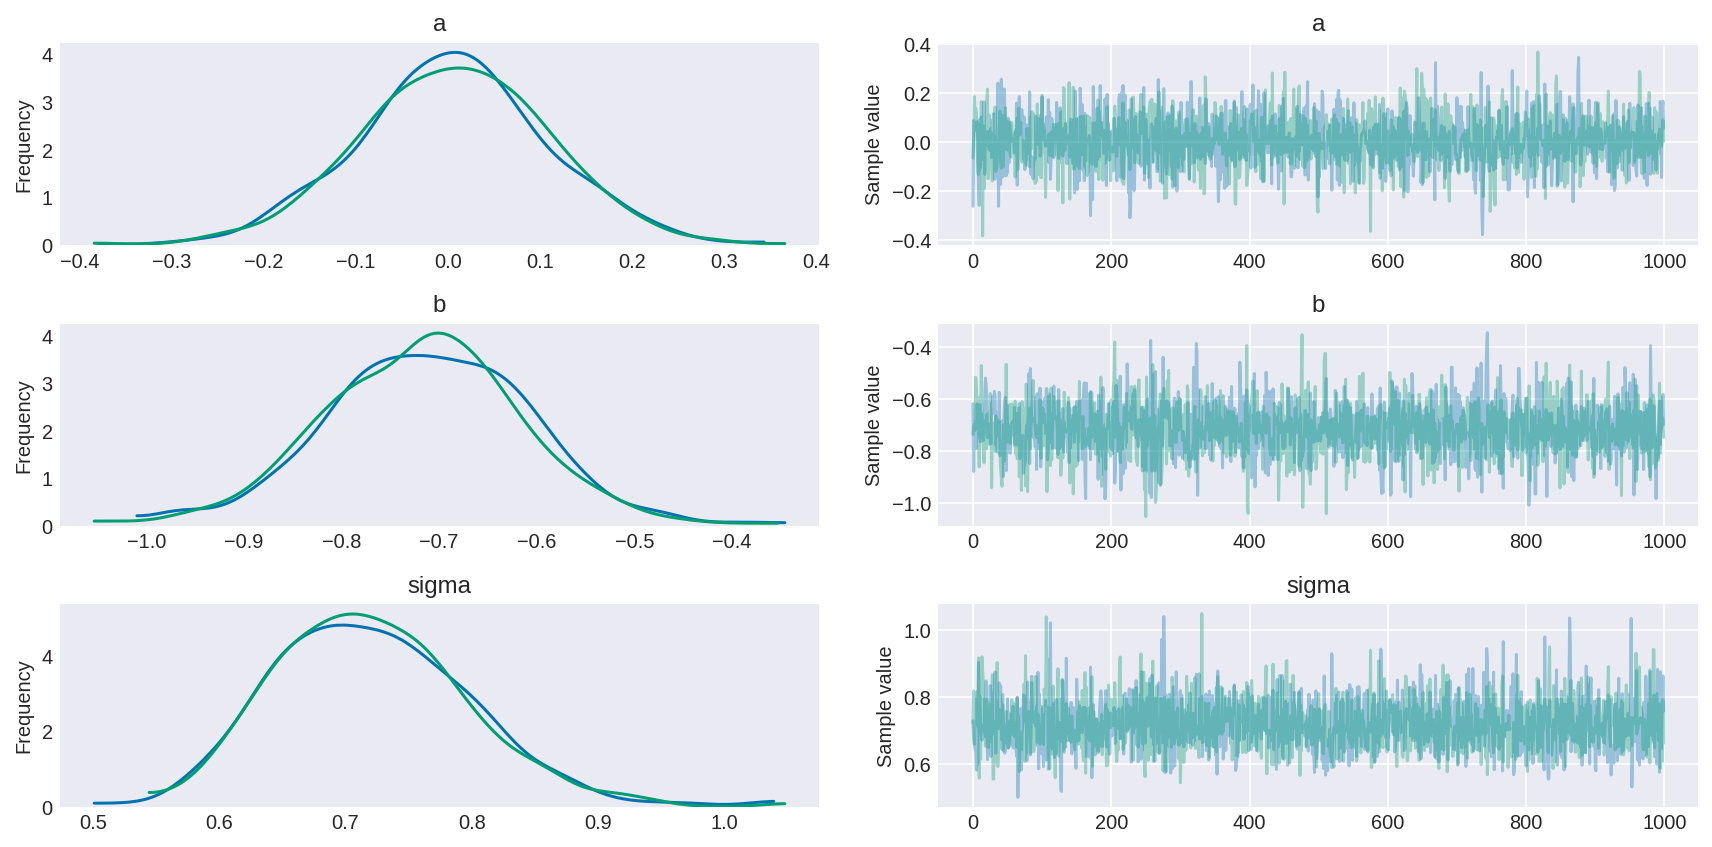

In [15]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [16]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

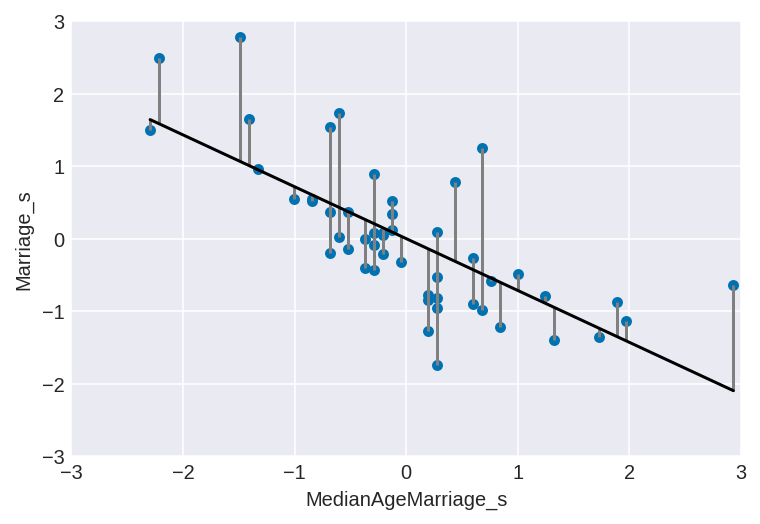

In [17]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

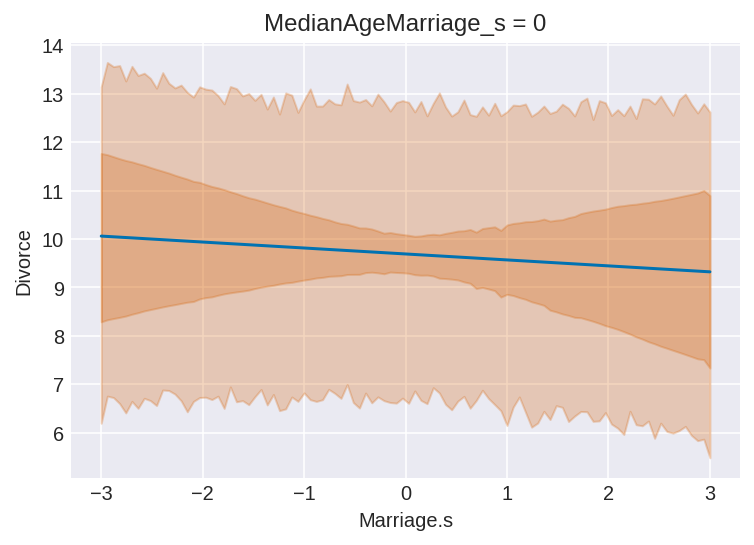

In [18]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

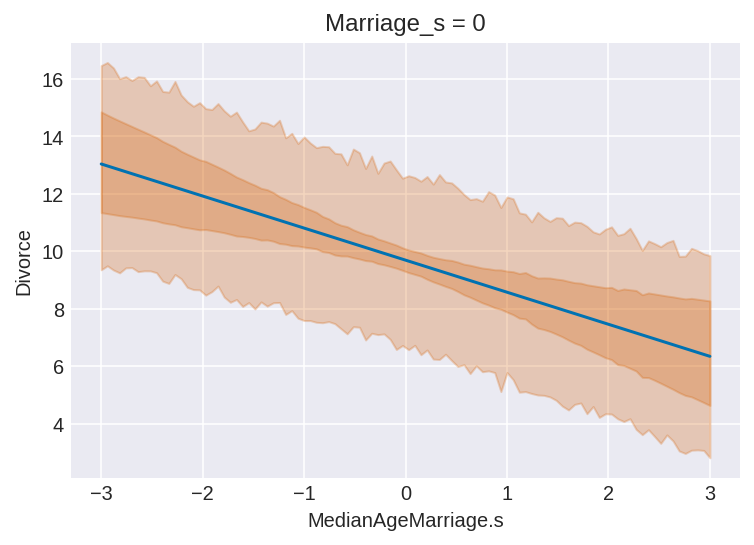

In [19]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [20]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:00<00:00, 2731.30it/s]


#### Code 5.12

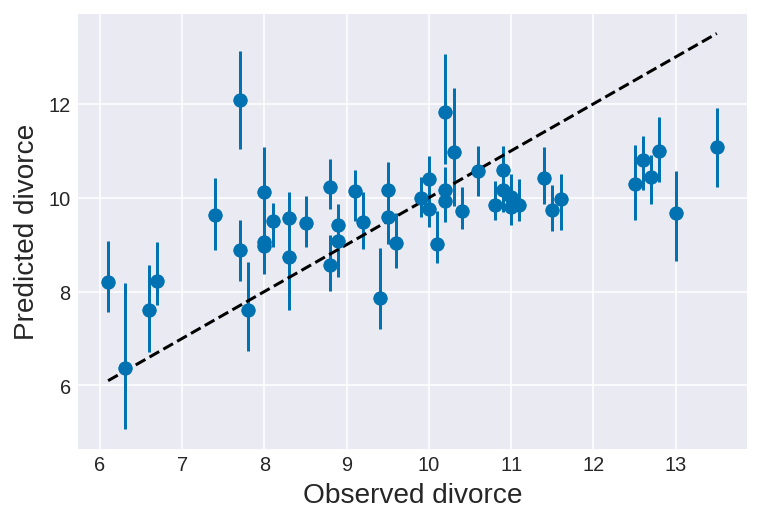

In [21]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='C0o')
plt.plot(d.Divorce, divorce_pred.mean(0), 'C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

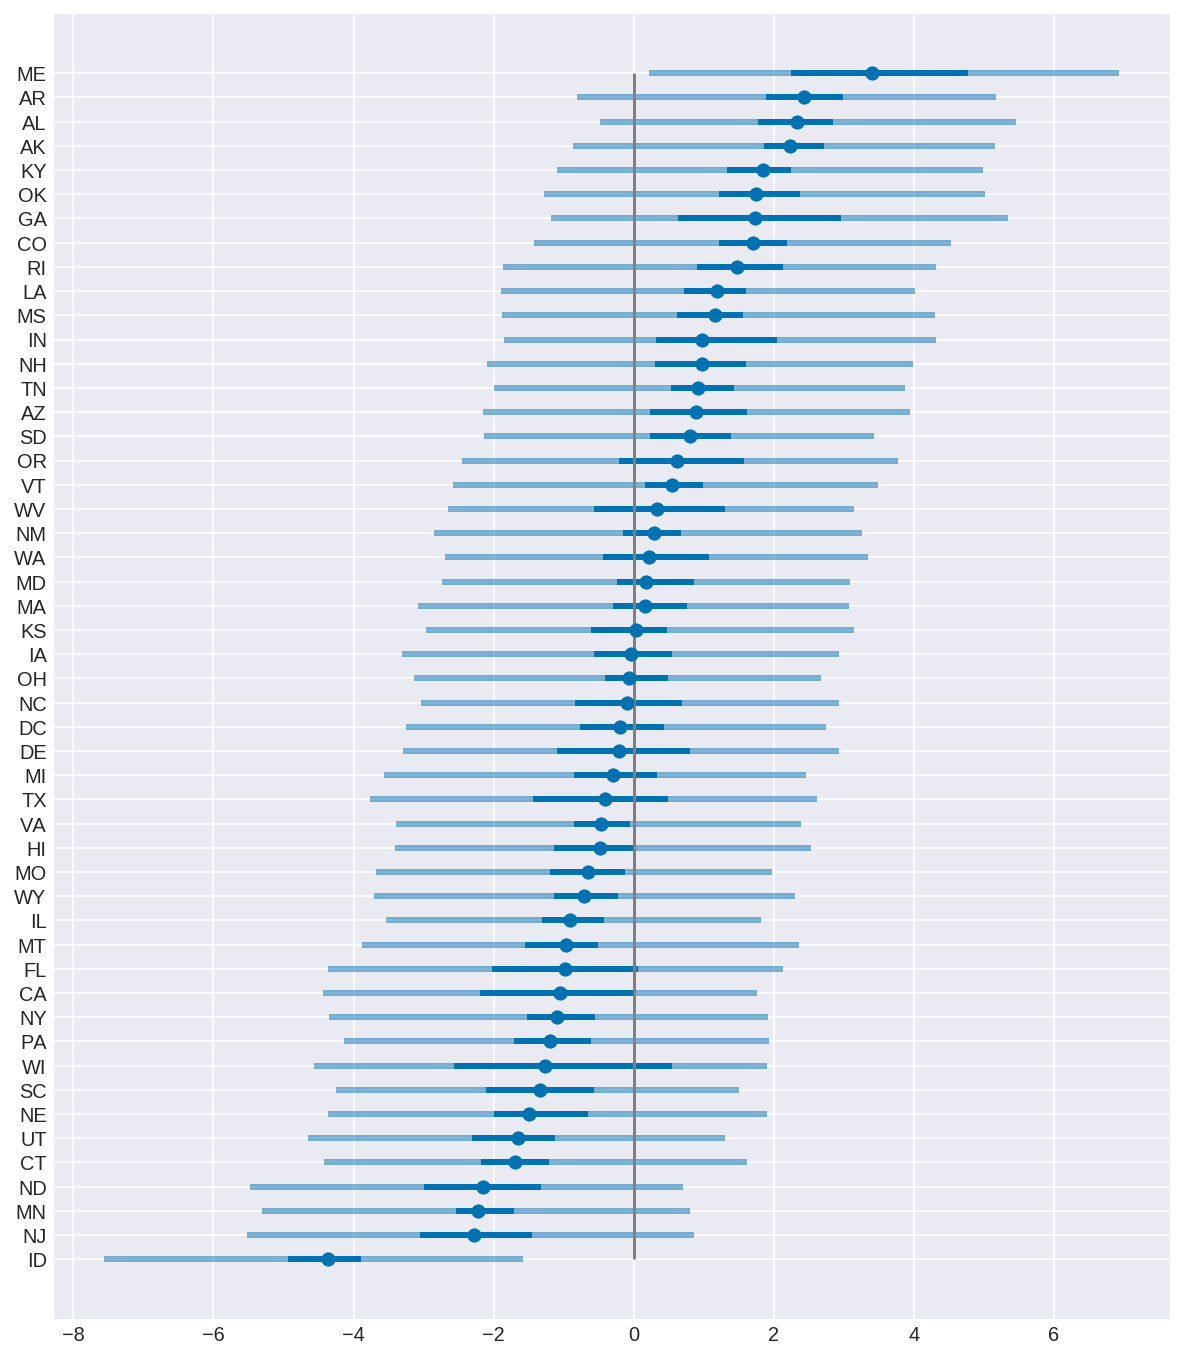

In [22]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.15

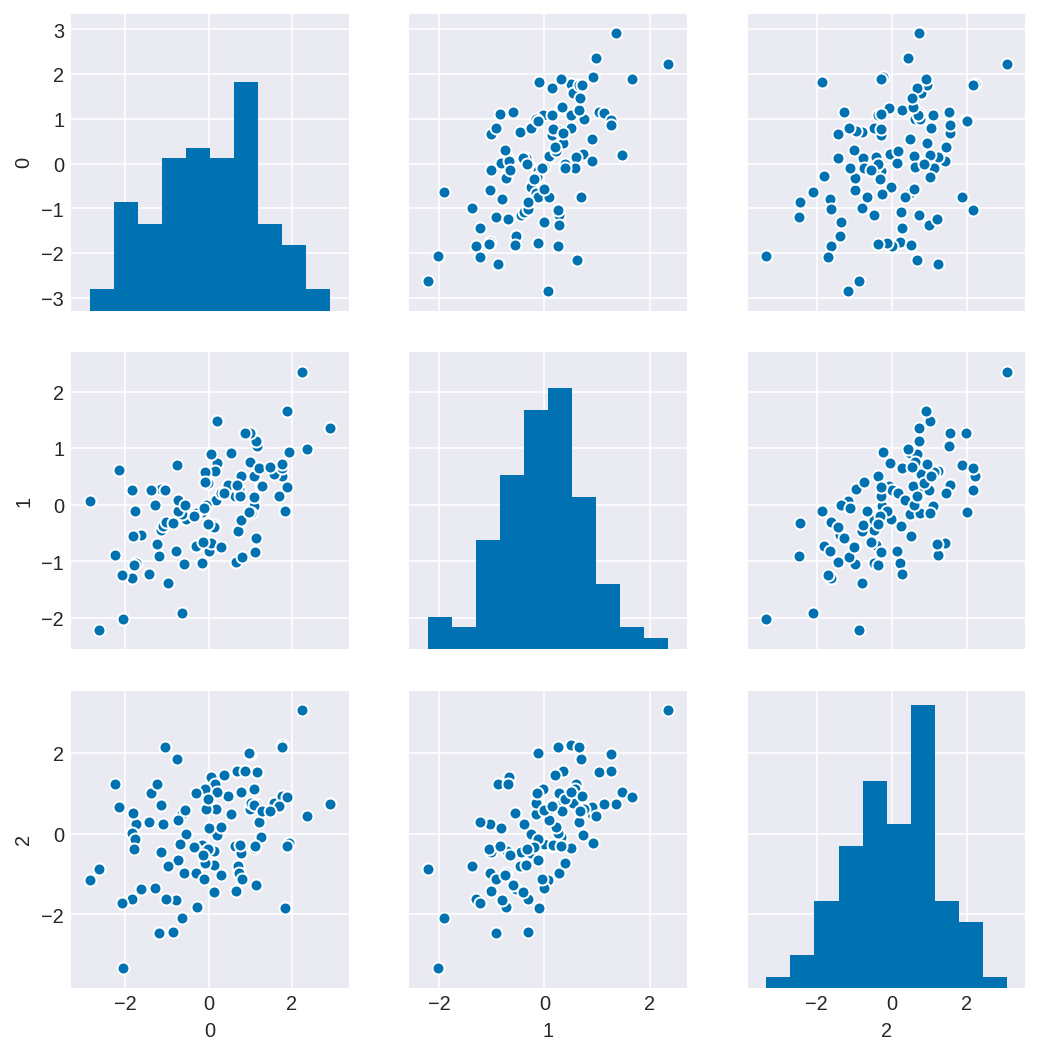

In [23]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [24]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

#### Code 5.17 to 5.20

In [25]:
dcc = d.dropna().copy()

In [26]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bn, a]
100%|██████████| 2000/2000 [00:10<00:00, 182.48it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


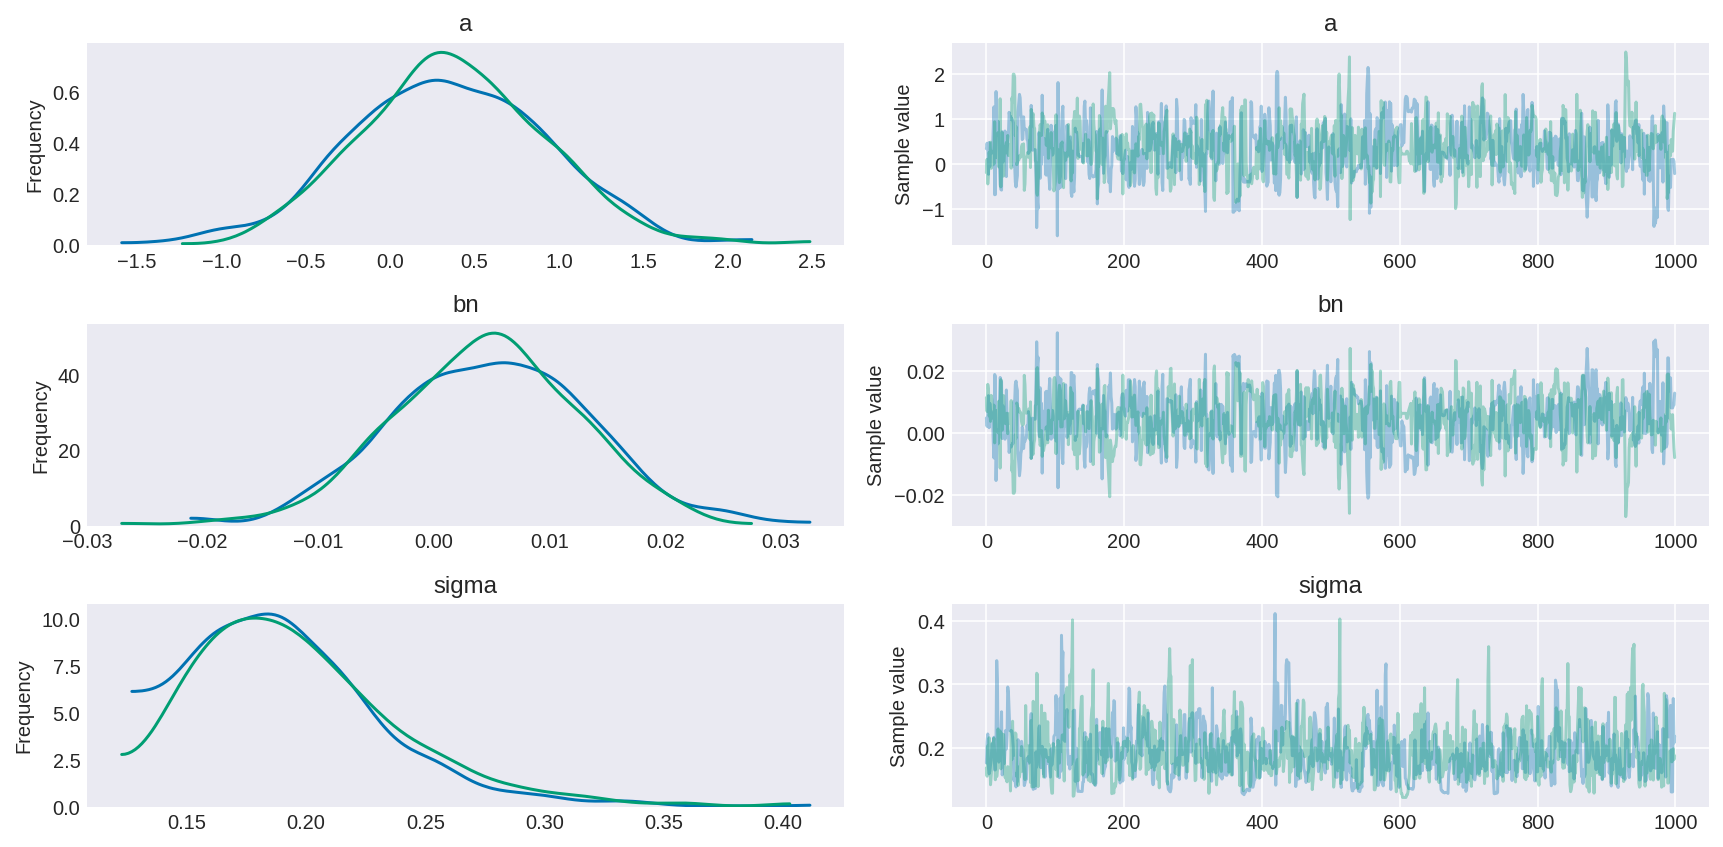

In [27]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [28]:
pm.summary(trace_5_5, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      0.353  0.561     0.022   -0.456     1.302  598.555  1.001
bn     0.005  0.008     0.000   -0.008     0.017  608.158  1.001
sigma  0.194  0.042     0.002    0.129     0.249  497.633  1.004

#### Code 5.22

In [29]:
trace_5_5['bn'].mean() * (76 - 55)

0.0954302549216778

#### Code 5.23

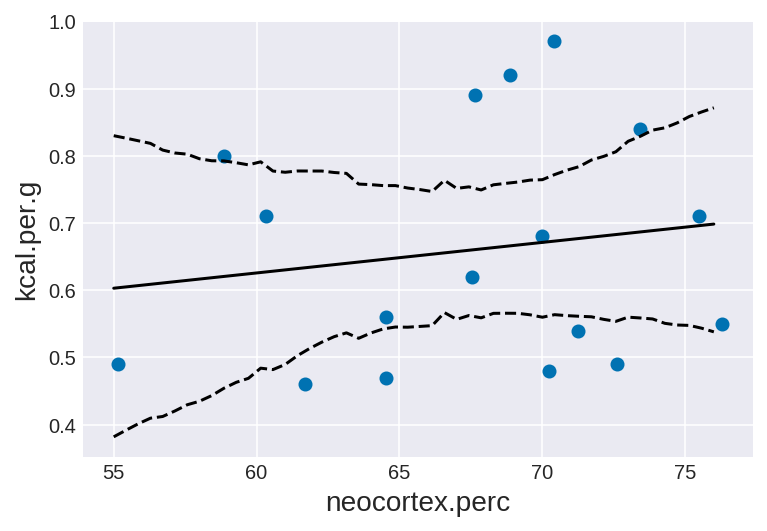

In [30]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

#### Code 5.24

In [31]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [32]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bn, a]
100%|██████████| 2000/2000 [00:02<00:00, 902.18it/s]


In [33]:
pm.summary(trace_5_6, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      0.706  0.061     0.002    0.607     0.799   839.987   1.0
bn    -0.032  0.025     0.001   -0.070     0.009   955.795   1.0
sigma  0.184  0.038     0.001    0.128     0.237  1150.980   1.0

#### Code 5.26

In [34]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bn, a]
100%|██████████| 2000/2000 [00:18<00:00, 106.01it/s]
The acceptance probability does not match the target. It is 0.8954495447364184, but should be close to 0.8. Try to increase the number of tuning steps.


In [35]:
pm.summary(trace_5_7, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a     -1.088  0.568     0.025   -1.983    -0.180  503.685  1.001
bn__0  0.028  0.009     0.000    0.013     0.041  501.152  1.001
bn__1 -0.097  0.028     0.001   -0.142    -0.052  632.149  1.000
sigma  0.141  0.029     0.001    0.097     0.184  543.746  1.004

#### Code 5.27

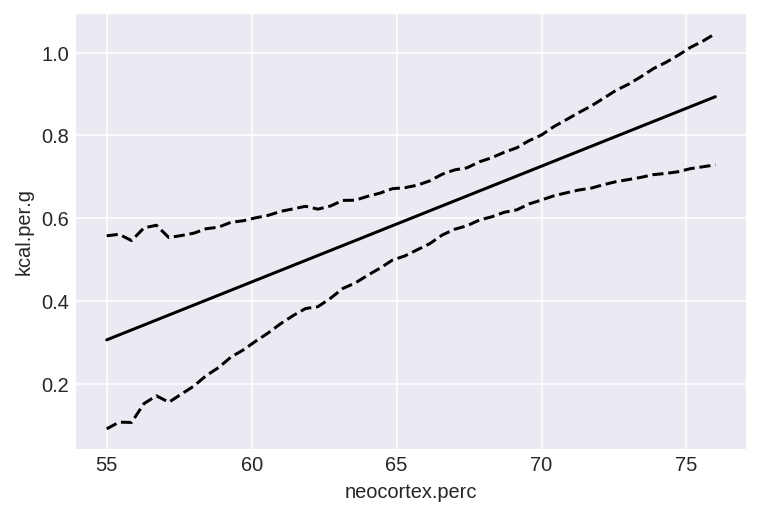

In [36]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

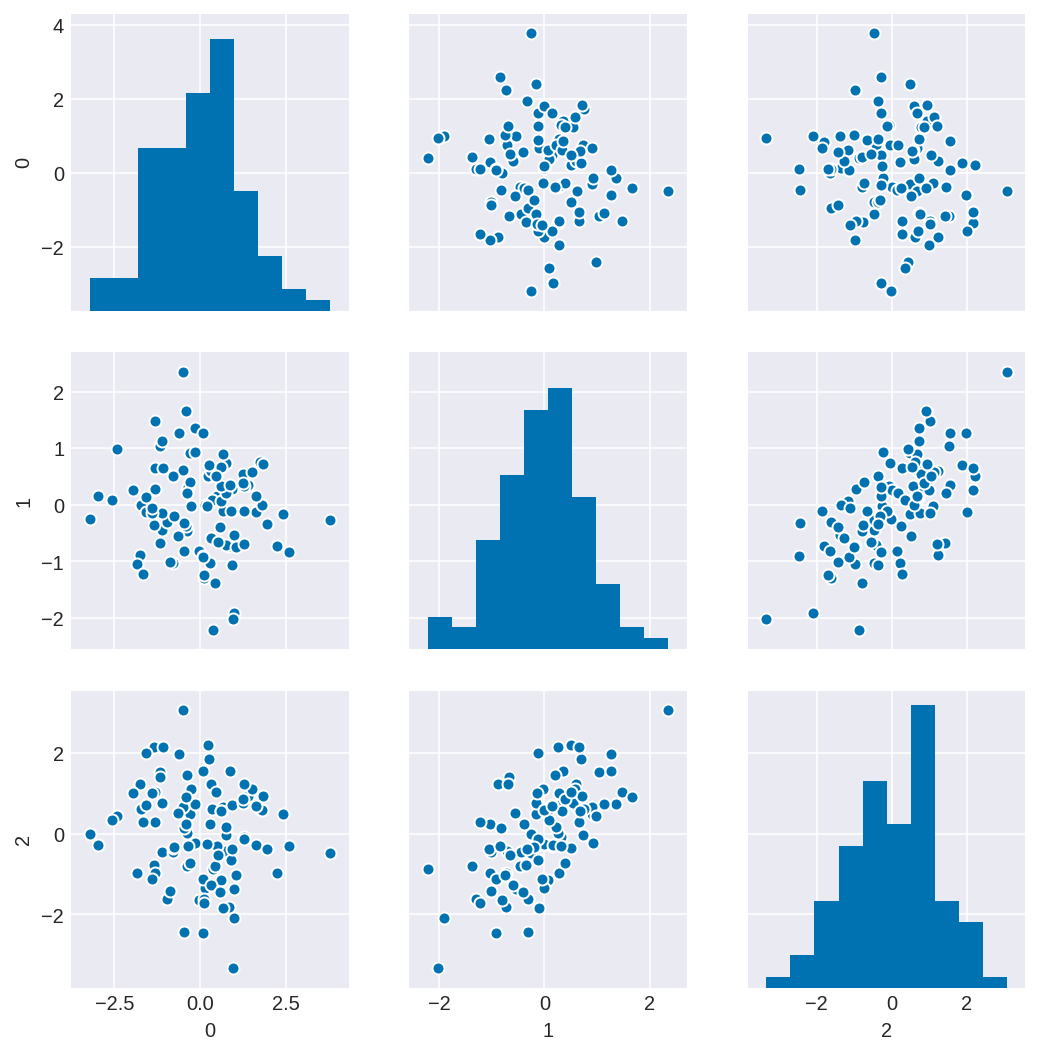

In [37]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [38]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

#### Code 5.30

In [39]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, br, bl, a]
100%|██████████| 2000/2000 [02:41<00:00, 12.38it/s]


mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      5.366  0.444     0.012    4.684     6.127  1288.742   1.0
bl    -2.592  4.069     0.150   -9.226     3.706   690.349   1.0
br     3.271  4.070     0.150   -2.937     9.990   689.436   1.0
sigma  1.449  0.106     0.003    1.276     1.612  1011.575   1.0

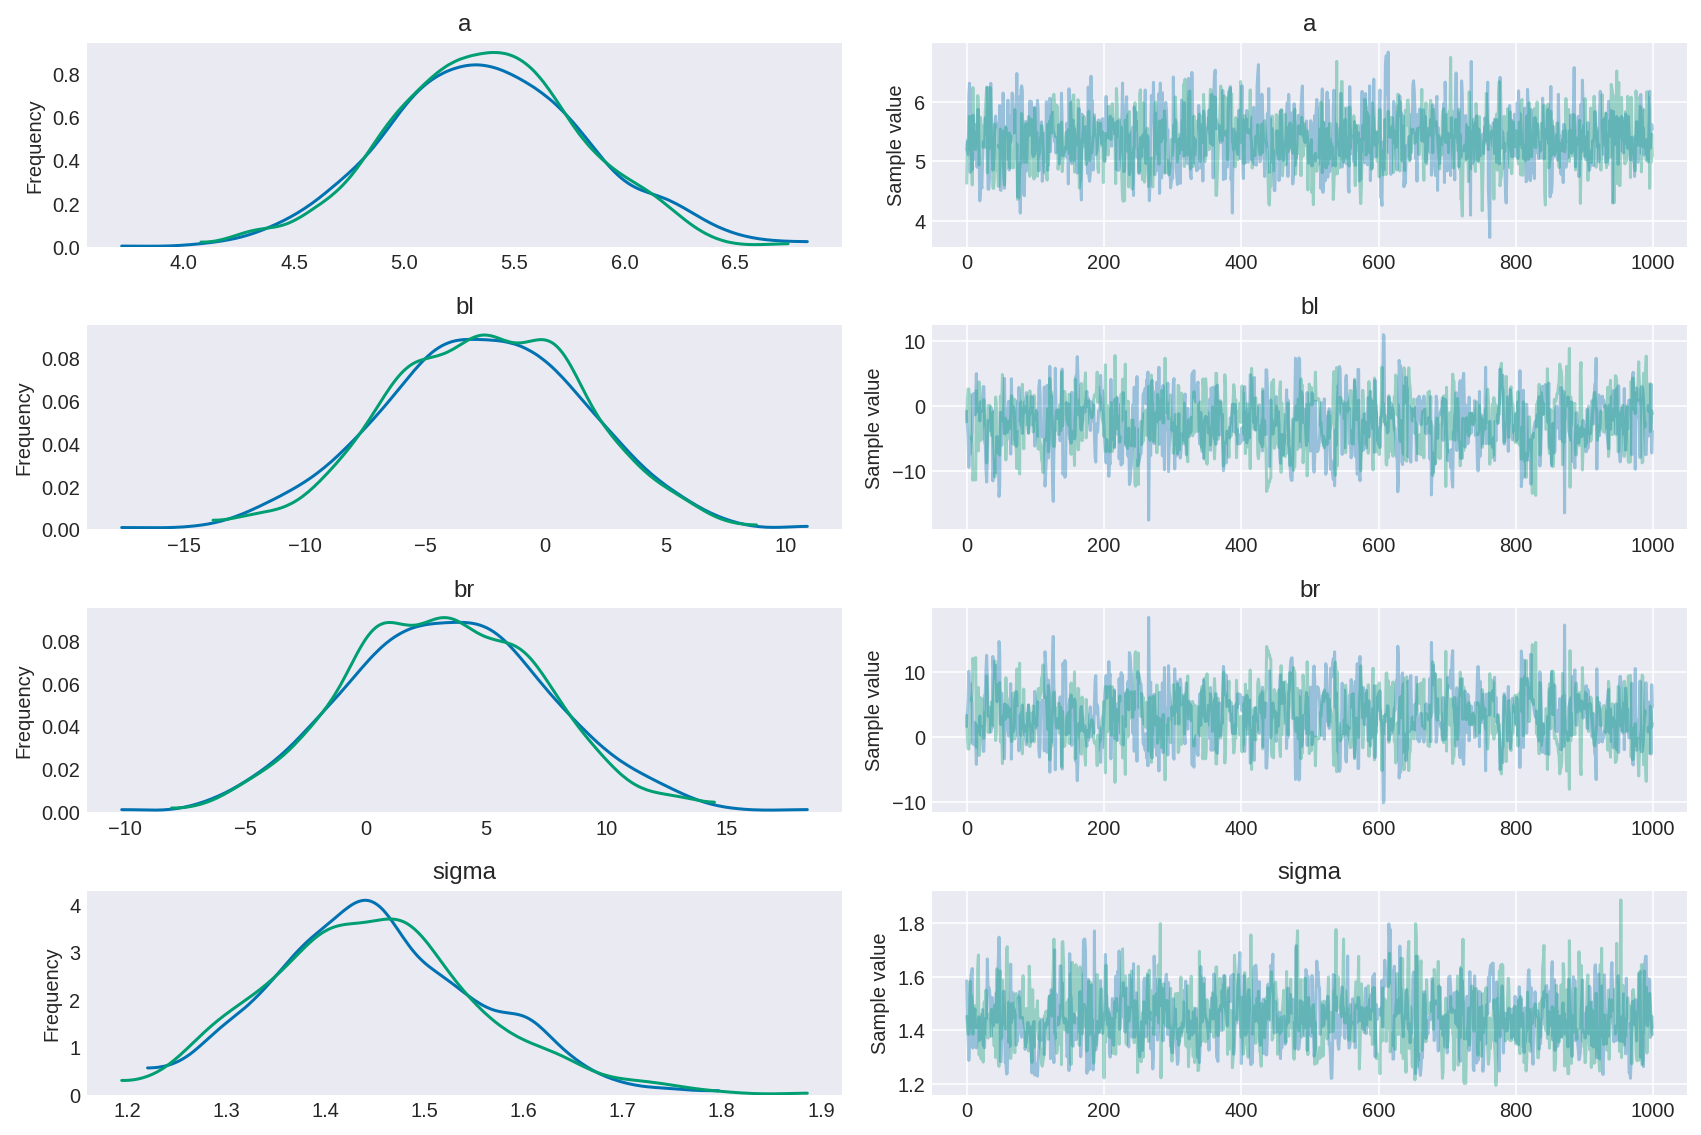

In [40]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);
pm.summary(trace_5_8, varnames, alpha=.11).round(3)

#### Code 5.31

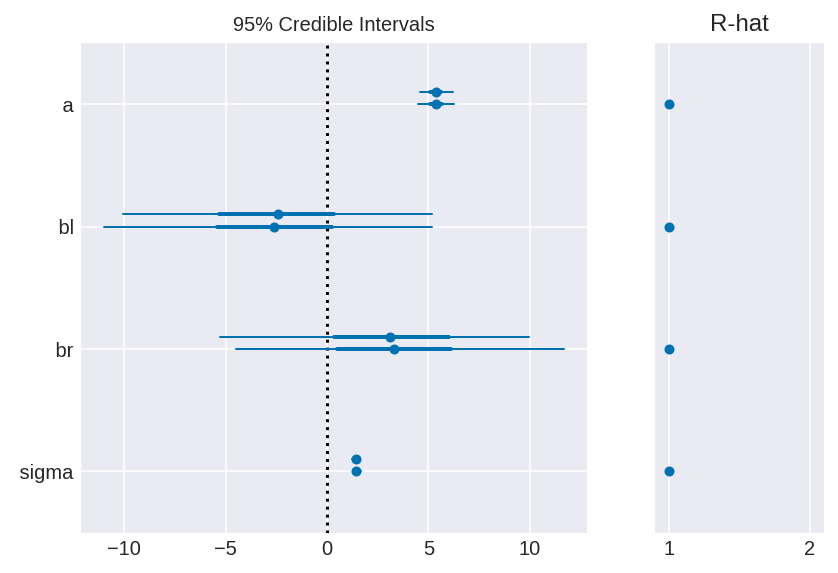

In [41]:
pm.forestplot(trace_5_8, varnames=varnames);

#### Code 5.32

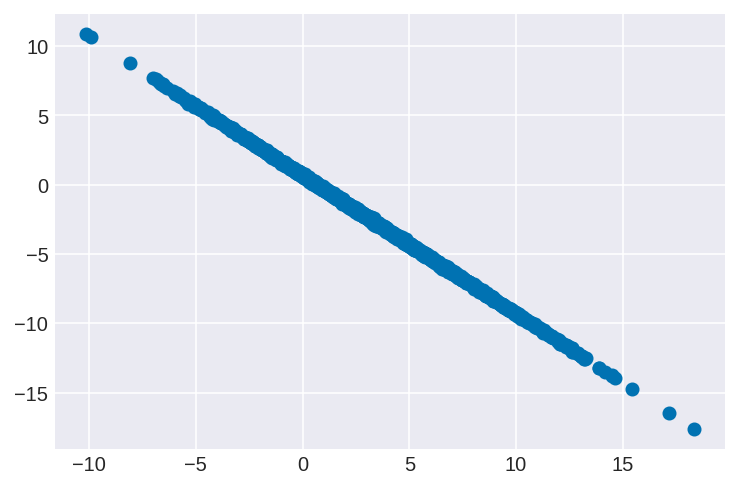

In [42]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

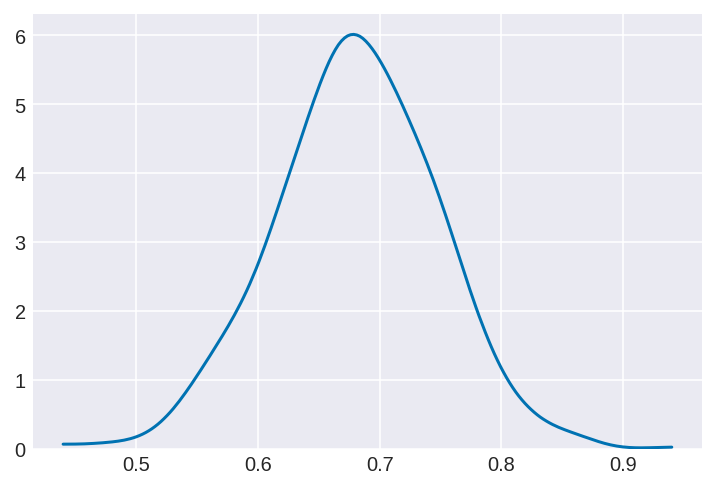

In [43]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
pm.kdeplot(sum_blbr);

#### Code 5.34

In [44]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bl, a]
100%|██████████| 2000/2000 [00:03<00:00, 560.87it/s]


In [45]:
varnames_1 = ['a', 'bl', 'sigma']
#pm.traceplot(trace_5_9, varnames_1)
pm.summary(trace_5_9, varnames_1, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      5.347  0.438     0.015    4.634     6.012  766.073   1.0
bl     0.684  0.066     0.002    0.581     0.788  752.600   1.0
sigma  1.454  0.104     0.003    1.281     1.619  971.297   1.0

#### Code 5.35

In [46]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

#### Code 5.36

In [47]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bf, a]
100%|██████████| 2000/2000 [00:04<00:00, 472.87it/s]


In [48]:
varnames = ['a', 'bf', 'sigma']
pm.summary(trace_5_10, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.30  0.040     0.001    0.232     0.360  781.432   1.0
bf     0.01  0.001     0.000    0.008     0.012  787.216   1.0
sigma  0.08  0.012     0.000    0.061     0.097  804.563   1.0

In [49]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bl, a]
100%|██████████| 2000/2000 [00:05<00:00, 365.78it/s]
The acceptance probability does not match the target. It is 0.8960653210171213, but should be close to 0.8. Try to increase the number of tuning steps.


In [50]:
varnames = ['a', 'bl', 'sigma']
pm.summary(trace_5_11, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      1.169  0.047     0.002    1.099     1.247  637.534   1.0
bl    -0.011  0.001     0.000   -0.012    -0.009  649.162   1.0
sigma  0.067  0.010     0.000    0.052     0.081  897.745   1.0

#### Code 5.37

In [51]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bl, bf, a]
100%|██████████| 2000/2000 [00:14<00:00, 137.67it/s]


In [52]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.summary(trace_5_12, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      1.002  0.220     0.009    0.643     1.335  582.502   1.0
bf     0.002  0.003     0.000   -0.002     0.006  598.564   1.0
bl    -0.009  0.003     0.000   -0.013    -0.004  593.543   1.0
sigma  0.068  0.009     0.000    0.053     0.081  689.334   1.0

#### Code 5.38

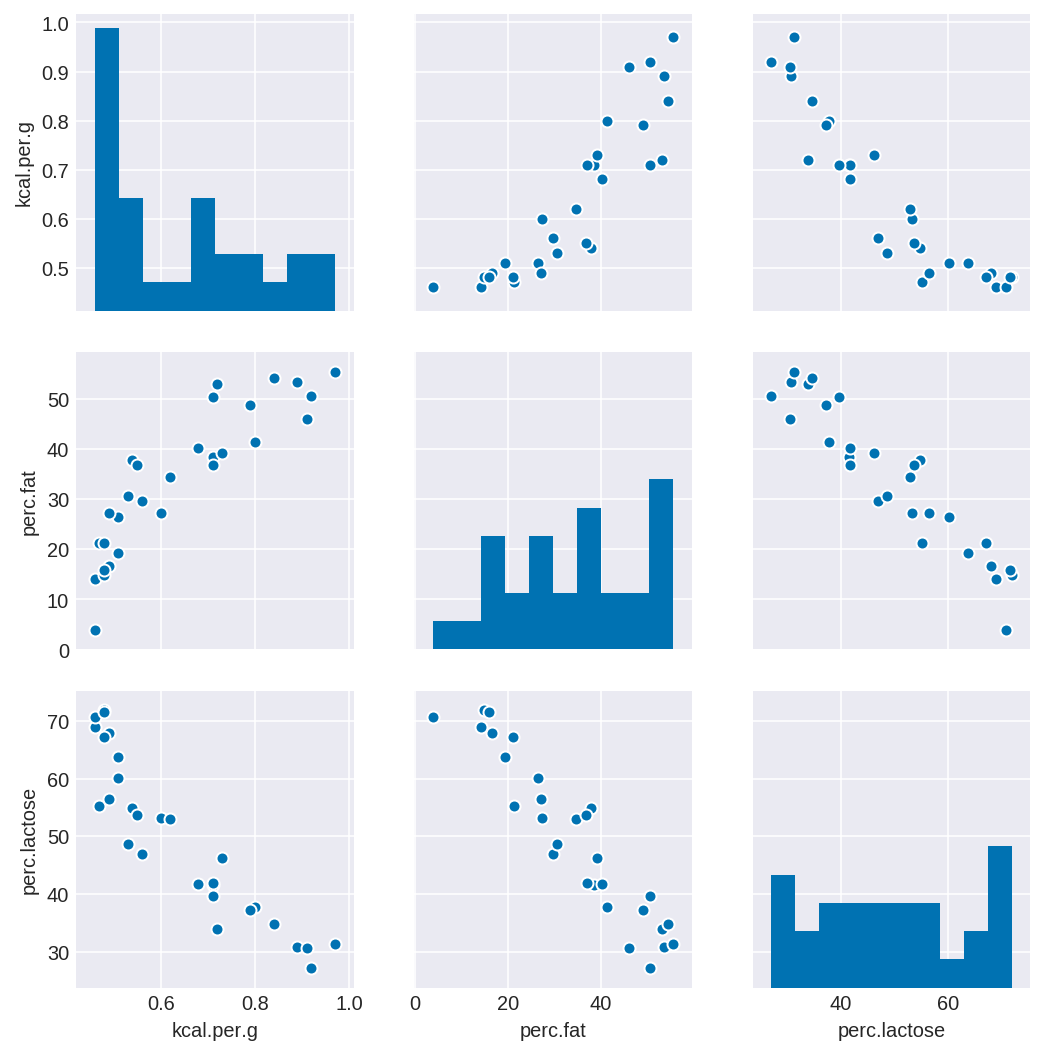

In [53]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.39

In [54]:
milk.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

#### Code 5.40

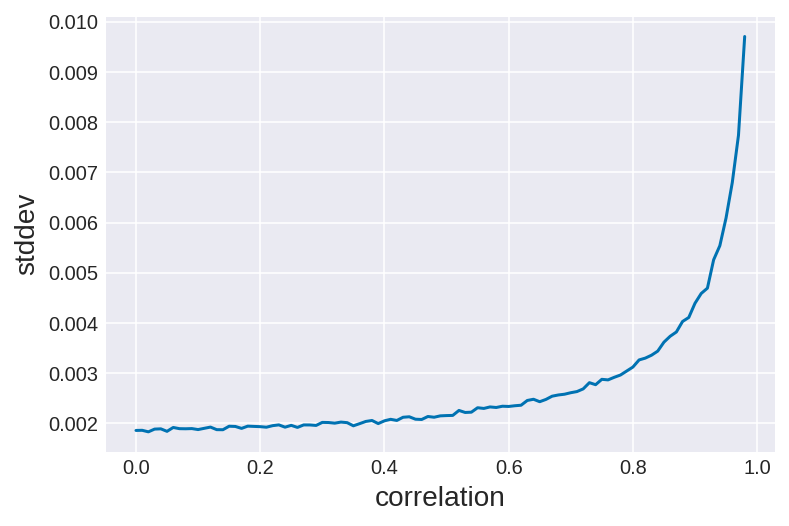

In [55]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 5.41

In [56]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

#### Code 5.42

In [57]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bf, bt, bh, a]
100%|██████████| 2000/2000 [00:08<00:00, 247.68it/s]
The acceptance probability does not match the target. It is 0.8994462772182725, but should be close to 0.8. Try to increase the number of tuning steps.


In [58]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.summary(trace_5_13, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      5.527  0.544     0.016    4.635     6.401   929.688   1.0
bh     0.964  0.050     0.001    0.884     1.044   969.206   1.0
bt    -0.018  0.231     0.007   -0.377     0.344  1131.348   1.0
bf    -3.045  0.246     0.007   -3.432    -2.637  1151.618   1.0
sigma  0.968  0.072     0.002    0.851     1.080  1408.894   1.0

#### Code 5.43

In [59]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bt, bh, a]
100%|██████████| 2000/2000 [00:06<00:00, 292.51it/s]


In [60]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.summary(trace_5_14, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      4.467  0.882     0.033    3.133     5.875   673.923  1.000
bh     0.931  0.083     0.003    0.795     1.052   694.202  1.000
bt     1.191  0.315     0.008    0.690     1.671  1334.813  1.003
sigma  1.563  0.117     0.003    1.370     1.738  1372.768  1.000

#### Code 5.44

In [2]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 5.45

In [62]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bm, a]
100%|██████████| 2000/2000 [00:02<00:00, 926.10it/s]


In [63]:
varnames = ['a', 'bm', 'sigma']
pm.summary(trace_5_15, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      134.791  1.614     0.044  132.252   137.386  1401.939   1.0
bm       7.333  2.303     0.069    3.636    10.995  1185.163   1.0
sigma   27.446  0.855     0.022   26.094    28.805  1346.387   1.0

#### Code 5.46

In [64]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu.male)

array([138.84963624, 145.47040633])

#### Code 5.47

In [65]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, am, af]
100%|██████████| 2000/2000 [00:01<00:00, 1002.57it/s]


#### Code 5.48

In [3]:
d = pd.read_csv('Data/milk.csv', sep=';')
d = d.drop_duplicates()

#### Code 5.49

In [4]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

#### Code 5.50

In [5]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

#### Code 5.51

In [69]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])
    
    # instead of adding this as a deterministic when running the model 
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16[a] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, b_S, b_OWM, b_NWM, a]
100%|██████████| 2000/2000 [00:03<00:00, 630.57it/s]


In [70]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)

mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff   Rhat
a      0.545  0.044     0.001    0.477     0.613   940.131  1.004
b_NWM  0.170  0.062     0.002    0.068     0.266  1131.890  1.002
b_OWM  0.244  0.068     0.002    0.141     0.360  1143.433  1.001
b_S   -0.037  0.071     0.002   -0.152     0.072  1010.296  1.003
sigma  0.130  0.020     0.001    0.100     0.160  1360.034  1.000

#### Code 5.52

In [71]:
varnames = ['mu_ape', 'mu_NWM', 'b_OWM', 'b_S']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]

mean     sd  hpd_5.5  hpd_94.5
mu_ape  0.545  0.044    0.477     0.613
mu_NWM  0.714  0.044    0.643     0.781
b_OWM   0.244  0.068    0.141     0.360
b_S    -0.037  0.071   -0.152     0.072

#### Code 5.53

In [72]:
diff_NMW_OWM = trace_5_16['mu_NWM'] - trace_5_16['mu_OWM']
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

(-0.21252408528344444, -0.07421477751573335, 0.060133190674783614)

#### Code 5.54

In [6]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

#### Code 5.55

In [7]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10, shape=len(d['clade_id'].unique()))
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = a[d['clade_id'].values], sd=sigma, observed = d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ps/anaconda2/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2000/2000 [00:01<00:00, 1726.49it/s]


In [10]:
varnames = ['a', 'sigma']
pm.summary(trace_5_16_alt, varnames, alpha=.11)


a:

  Mean             SD               MC Error         89% HPD interval
  -------------------------------------------------------------------
  
  0.545            0.043            0.001            [0.466, 0.603]
  0.715            0.044            0.001            [0.651, 0.789]
  0.787            0.052            0.001            [0.701, 0.863]
  0.507            0.058            0.002            [0.417, 0.600]

  Posterior quantiles:
  5.5            25             50             75             94.5
  |--------------|==============|==============|--------------|
  
  0.473          0.516          0.544          0.574          0.616
  0.646          0.687          0.716          0.744          0.785
  0.705          0.752          0.788          0.820          0.868
  0.413          0.469          0.508          0.547          0.598


sigma:

  Mean             SD               MC Error         89% HPD interval
  -------------------------------------------------------------------


The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [76]:
data  = pd.read_csv('Data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)

In [77]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
Pandas 0.22.0
SciPy 1.0.1
Matplotlib 2.2.2
Seaborn 0.8.1



# Practice
## Easy

### 5E1
Which of the linear models below are multiple linear regressions?

$$ \mu_i = \alpha + \beta x_i $$
$$ \mu_i = \beta_x x_i + \beta_z z_i $$
$$ \mu_i = \alpha + \beta(x_i - z_i) $$
$$ \mu_i = \alpha + \beta_x x_i + \beta_z z_i $$

> All but the first are multivariate linear regressions

### 5E2 
Write down a multiple regression to evaluate the claim: Animal diversity is linearly related to latitutde, but only after controlling for plant diversity. Write down the model definition.  

$$ d_i \sim \mathcal{N}(\mu_i, \sigma_i) $$
$$ \mu_i = \alpha + \beta_l l_i + \beta_p p_i  $$

### 5E3
Write down a multiple regression to evaluate the claim: Neither amount of funding nor size of laboratory is by itself a good predictor of time to a PhD; but together these variables are both positively associated with time to degree. Write down the model definition and indicate which side of zero each slope parameter should be on.

$$ t_i \sim \mathcal{N}(\mu_i, \sigma_i) $$
$$ \mu_i = \alpha + \beta_f f_i + \beta_l l_i $$

> Both $\beta$ coefficients should be positive since the prompt states they are positively associated. 

### 5E4
Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C, and D. Let $A_i$ be an indicator variables that is 1 where case $i$ is in category $A$. Also suppose $B_i$, $C_i$, and $D_i$ for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it's possible to compute one posterior distribution of another model.

$$ \mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_D D_i $$
$$ \mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i $$
$$ \mu_i = \alpha + \beta_B B_i + \beta_C C_i + \beta_D D_i $$
$$ \mu_i = \alpha_A A_i + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i $$
$$ \mu_i = \alpha_A(1 - B_i - C_i - D_i) + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i $$

> General rule: To include $k$ categories, you require $k-1$ dummy variables. Each dummy variable indicates, with the value 1, a unique category. The category with no dummy variable assigned to it ends up as the intercept category. 1 and 3 are equivalent as the intercept term counts as the missing variable. 

## Medium

### 5M1
Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables, but when both predictors are entered into the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

In [6]:
import scipy.stats as st
import pymc3 as pm

In [14]:
N = 100
x_real = st.norm.rvs(size=N) # mean 0, sd 1
x_spur = st.norm.rvs(loc=x_real, size=N)
y = st.norm.rvs(loc=x_real, size=N)

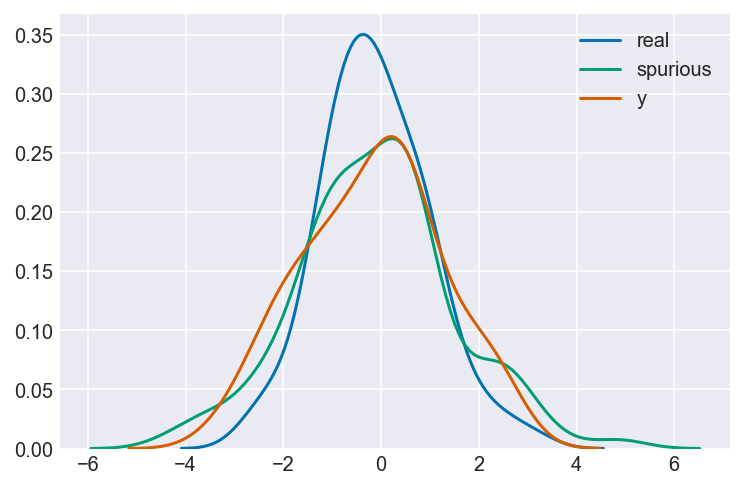

In [18]:
sns.kdeplot(x_real, label='real')
sns.kdeplot(x_spur, label='spurious')
sns.kdeplot(y, label='y');

In [25]:
df = pd.DataFrame([y, x_real, x_spur]).T
df.columns = ['y', 'x_real', 'x_spur']
df.head()

y    x_real    x_spur
0  0.438186  0.218344 -0.073896
1 -3.071703 -2.367349 -1.354152
2 -1.154013 -0.936178 -1.038580
3  0.613859 -0.017215 -1.419279
4  0.634818  0.726260 -1.287207

Check the slope of each predictor variable separately

In [33]:
slope_x_real, *_ = st.linregress(df.y, df.x_real)
slope_x_spur, *_ = st.linregress(df.y, df.x_spur)
slope_x_real, slope_x_spur

(0.5755495025997168, 0.5624480410768229)

Check slopes when combined into a multivariate model, the spurious correlation's slope should vanish.

In [34]:
from sklearn import linear_model

In [38]:
reg = linear_model.LinearRegression()
reg.fit(df[['x_real', 'x_spur']], df['y'])
reg.coef_

array([ 0.99196871, -0.02091136])

### 5M2
Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another. 

In [42]:
N = 100
corr = 0.7
x_pos = st.norm.rvs(size=100)
x_neg = st.norm.rvs(loc=corr*x_pos, scale=np.sqrt(1-corr**2), size=100)

y = st.norm.rvs(x_pos - x_neg, size=100)

In [45]:
df = pd.DataFrame([y, x_pos, x_neg]).T
df.columns = ['y', 'x_pos', 'x_neg']
df.head(2)

y     x_pos     x_neg
0  3.474472  1.793317  0.460417
1  2.969255  2.117771  0.104305

In [46]:
slope_x_pos, *_ = st.linregress(df.y, df.x_pos)
slope_x_neg, *_ = st.linregress(df.y, df.x_neg)
slope_x_pos, slope_x_neg

(0.2247012517804106, -0.2322859577994271)

In [47]:
reg = linear_model.LinearRegression()
reg.fit(df[['x_pos', 'x_neg']], df['y'])
reg.coef_

array([ 1.07109529, -1.03328279])

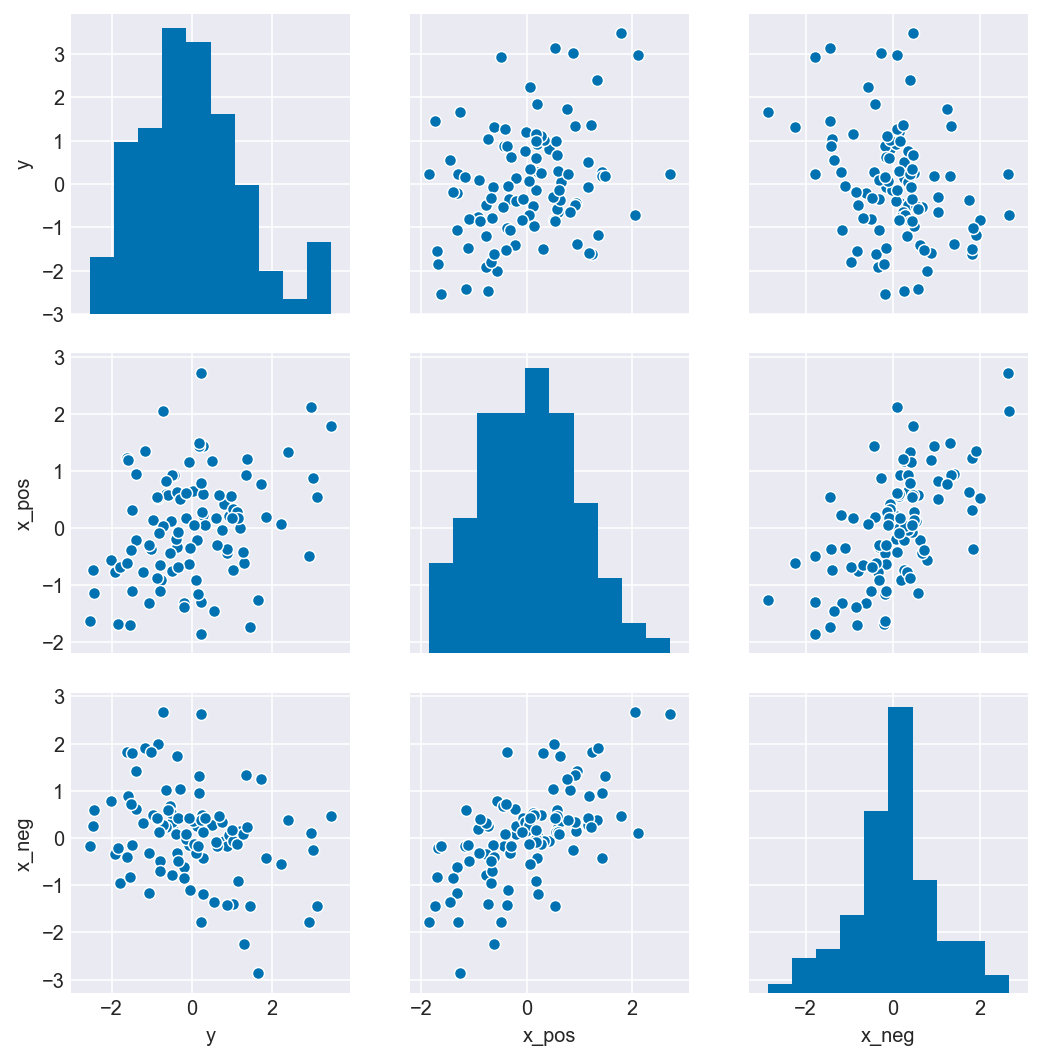

In [49]:
sns.pairplot(df);

### 5M3
It is sometimes observed that the best predictor of fire risk is the presence of firefighters. States and localities with many firefighters also have more fires. Presumably firefighters do not _cause_ fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of  way to evalute this relationship, using multiple regression?

> A high divorce rate can cause a higher marriage rate because the same people can be getting constantly divorced and remarried. You could evaluate this by predicting marriage rate (as the dependent variable) to divorce rates and median age of marriage.

### 5M4
In the divorce data, states with high numbers of Mormons have much lower divorce rates than the regression model expected. Find a list of LDS population by state and use those numbers as predictor variable, predicting divorce rates using marriage rate, median age of marriage, and percent LDS population. You may want to consider transformations of the raw percent LDS variable. 

In [80]:
url = 'https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States)'

lds = pd.read_html(url)
lds = lds[1]
lds.columns = lds.iloc[0]
lds = lds[1:]
lds.index = lds.State
lds['perc'] = [float(x[:-1]) for x in lds.LDS]
lds.head(2)

0          State Membership Population    LDS Temples Missions Congregations  \
State                                                                          
Alabama  Alabama      37487    4874747  0.77%       1        1            74   
Alaska    Alaska      33492     739795  4.53%       1        1            82   

0       Family History Centers  perc  
State                                 
Alabama                     44  0.77  
Alaska                      15  4.53

In [89]:
d.index = d.Location
d['perc_LDS'] = lds.perc
d['perc_LDS_s'] = (d.perc_LDS - d.perc_LDS.mean()) / d.perc_LDS.std()
d.head(2)

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
Location                                                                      
Alabama   Alabama  AL        4.78               25.3      20.2         1.27   
Alaska     Alaska  AK        0.71               25.2      26.0         2.93   

          Divorce  Divorce SE  WaffleHouses  South  Slaves1860  \
Location                                                         
Alabama      12.7        0.79           128      1      435080   
Alaska       12.5        2.05             0      0           0   

          Population1860  PropSlaves1860  MedianAgeMarriage_s  Marriage_s  \
Location                                                                    
Alabama           964201            0.45            -0.606290    0.022644   
Alaska                 0            0.00            -0.686699    1.549802   

          perc_LDS  perc_LDS_s  
Location                        
Alabama       0.77   -0.262772  
Alaska        4.53    0.110715

$$ d_i \sim \mathcal{N}(\mu_i, \sigma_i) $$
$$ \mu_i = \alpha + \beta_a A_i + \beta_r R_i + \beta_m M_i $$

In [90]:
reg = linear_model.LinearRegression()
reg.fit(d[['MedianAgeMarriage_s', 'Marriage_s', 'perc_LDS_s']], d['Divorce'])
reg.coef_

array([-1.37641723,  0.00843412, -0.62535174])

This multivariate regression shows a negative correlation between Divorce and the percentage of Mormons that live in the state, controlling for marriage rate and median age of marriage. 

We can do the same regression but with PyMC3 and get uncertainty estimates for each coefficient as follows

In [91]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('a', 0, 10)
    beta = pm.Normal('b', 0, 10, shape=3)
    sigma = pm.InverseGamma('sig', 1)
    
    # Linear model
    mu = alpha + beta[0] * d.MedianAgeMarriage_s + beta[1] * d.Marriage_s + beta[2] * d.perc_LDS_s
    D = pm.Normal('d', mu, sigma, observed=d.Divorce)
    
    trace = pm.sample(200, njobs=4)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, b, a]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:04<00:00, 592.52draws/s] 


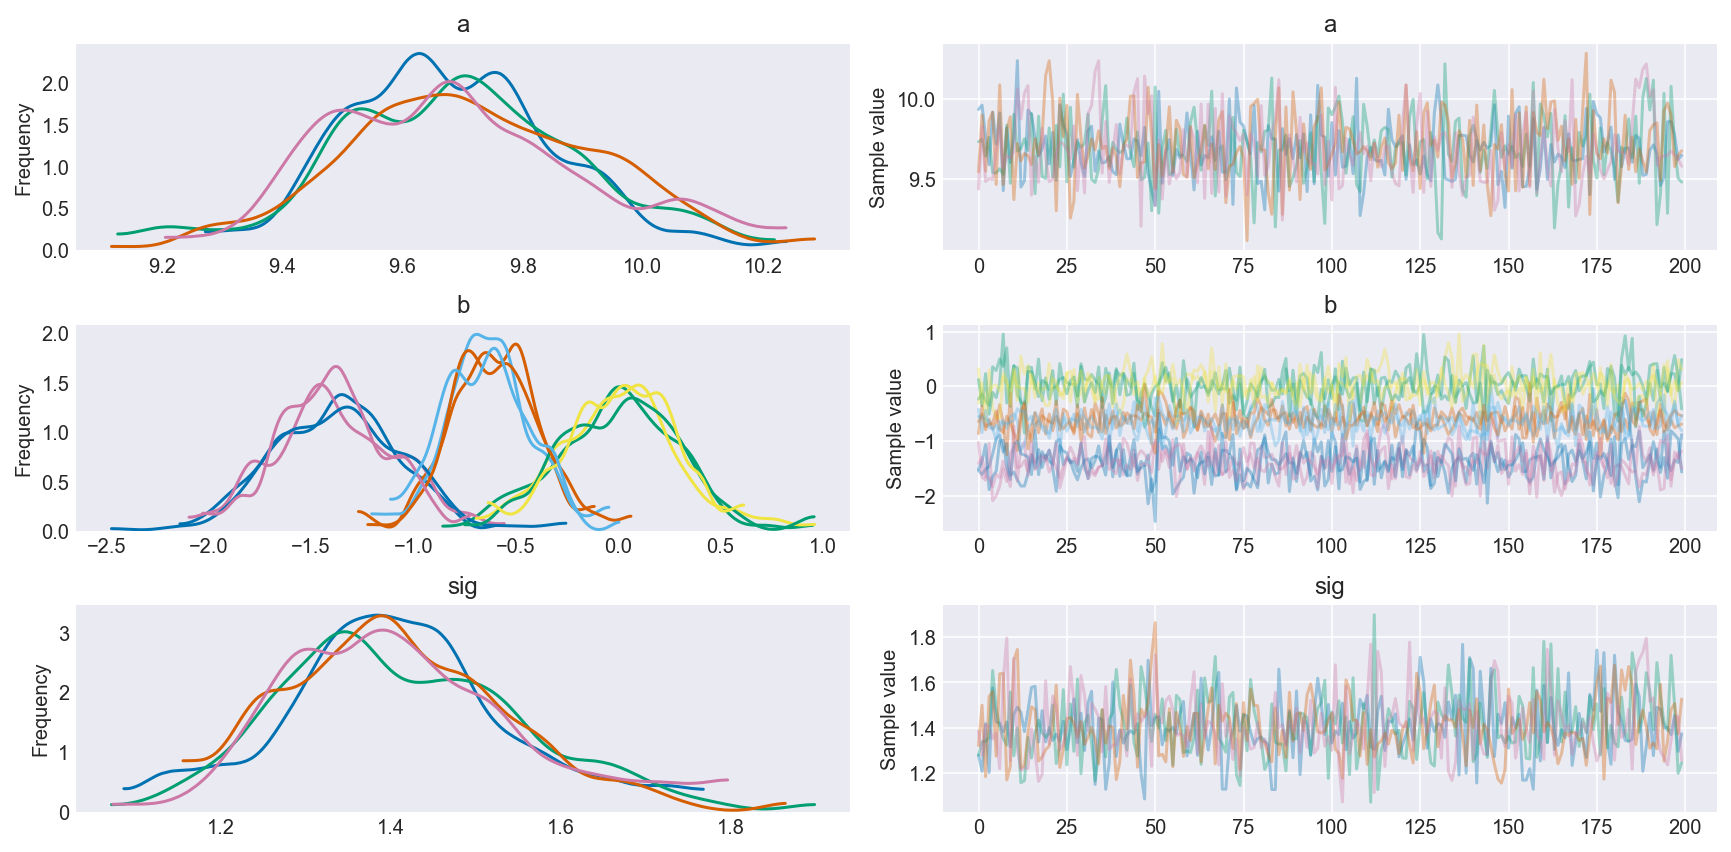

In [93]:
pm.traceplot(trace);

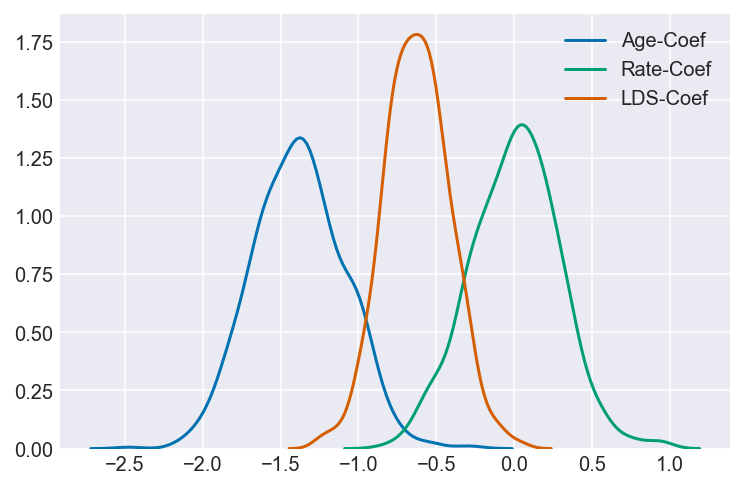

In [95]:
sns.kdeplot(trace['b'][:,0], label='Age-Coef')
sns.kdeplot(trace['b'][:,1], label='Rate-Coef')
sns.kdeplot(trace['b'][:,2], label='LDS-Coef');

**5M5** One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge resaurant meals. Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need. 

> Where $G$ is the price of gasoline, $E$ is the amount of exercise, and $R$ is the number of restaurant meals consumed.

$$ O_i \sim \mathcal{N}(\mu_i, \sigma_i) $$
$$ \mu_i = \alpha + \beta_G G_i + \beta_E E_i + \beta_R R_i $$



## Hard

All three exercises below use the same data. The urban fox (Vulpes vulpes) is a successful exploiter of human habitat. Since urban foxes move in packs and defend territories, data on habitat quality and population density is also included. The dataframe has five columns:

- Group:  number of the social group the individual belongs to
- avgfood: The average amount of food available
- groupsize: The number of foxes
- area: size of territory
- weight: body weight of the individual fox

In [96]:
df = pd.read_csv('Data/foxes.csv')
df.head(2)

group  avgfood  groupsize  area  weight
0      1     0.37          2  1.09    5.02
1      1     0.37          2  1.09    2.84

### 5H1 
Fit two bivariate Gaussian regressions. (1) Body weight as a linear function of territory size and (2) body weight as a linear function of groupsize. Plot the results of these regressions, displaying the MAP regression line and 95% interval of the mean. Is either variable important for predicting fox body weight?

In [104]:
with pm.Model() as model:
    alpha = pm.Normal('a', 0, 10)
    beta = pm.Normal('b', 0, 10)
    mu = alpha + beta * df.area
    
    sigma = pm.InverseGamma('sd', 1)
    w = pm.Normal('w', mu, sigma, observed=df.weight)
    trace = pm.sample(200, tune=1000)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains: 100%|██████████| 2400/2400 [00:04<00:00, 526.30draws/s]
The acceptance probability does not match the target. It is 0.8789303784715715, but should be close to 0.8. Try to increase the number of tuning steps.


#### Body weight as a linear function of territory size

Scatterplot with MAP fits

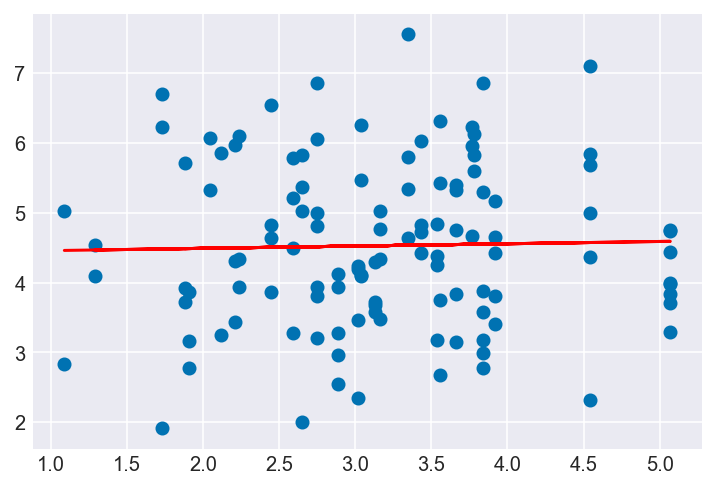

In [134]:
plt.scatter(df.area, df.weight)
x = np.linspace(*plt.xlim())
y = trace['a'].mean() + trace['b'].mean() * df.area
plt.plot(df.area, y, c='r')

$\mu$ HPD

In [135]:
mu_pred = np.zeros((len(x), len(trace)*trace.nchains))
for i, w in enumerate(x):
    mu_pred[i] = trace.a + trace.b * w
mu_hpd = pm.hpd(mu_pred.T)

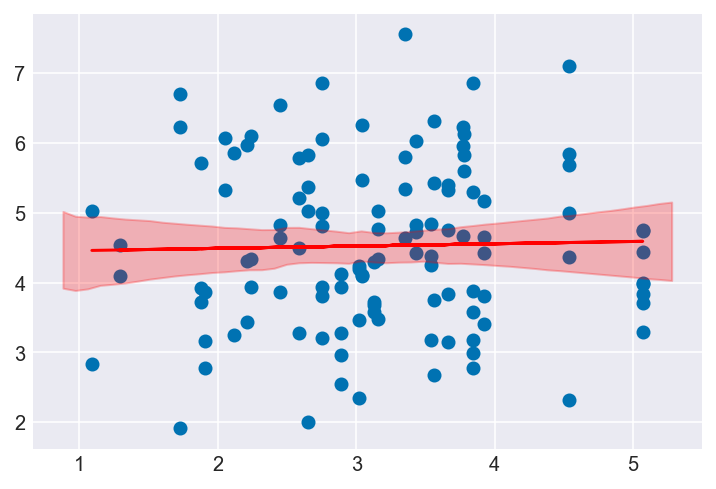

In [140]:
plt.scatter(df.area, df.weight)
x = np.linspace(*plt.xlim())
y = trace.a.mean() + trace.b.mean() * df.area
plt.plot(df.area, y, c='r')
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

#### Body weight as a linear function of group size

In [148]:
with pm.Model() as model:
    alpha = pm.Normal('a', 0, 10)
    beta = pm.Normal('b', 0, 10)
    mu = alpha + beta * df.groupsize
    
    sigma = pm.InverseGamma('sd', 1)
    w = pm.Normal('w', mu, sigma, observed=df.weight)
    trace = pm.sample(200, tune=1000)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains: 100%|██████████| 2400/2400 [00:04<00:00, 591.75draws/s]


Scatterplot with MAP fits

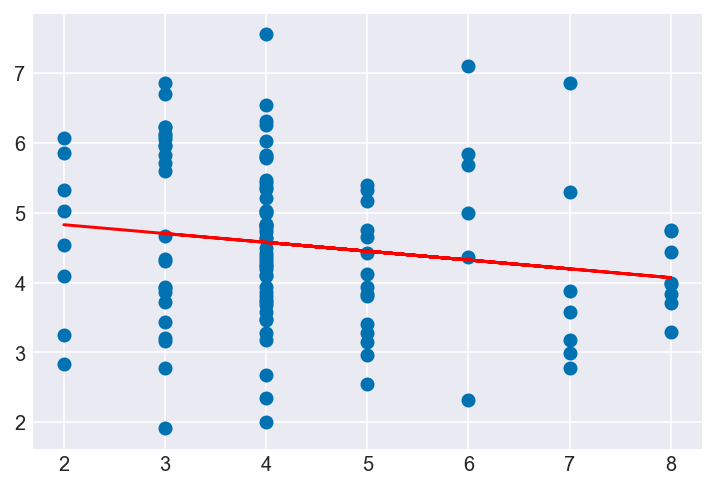

In [149]:
plt.scatter(df.groupsize, df.weight)
x = np.linspace(*plt.xlim())
y = trace.a.mean() + trace.b.mean() * df.groupsize
plt.plot(df.groupsize, y, c='r');

$\mu$ HPD

In [150]:
mu_pred = np.zeros((len(x), len(trace)*trace.nchains))
for i, w in enumerate(x):
    mu_pred[i] = trace.a + trace.b * w
mu_hpd = pm.hpd(mu_pred.T)

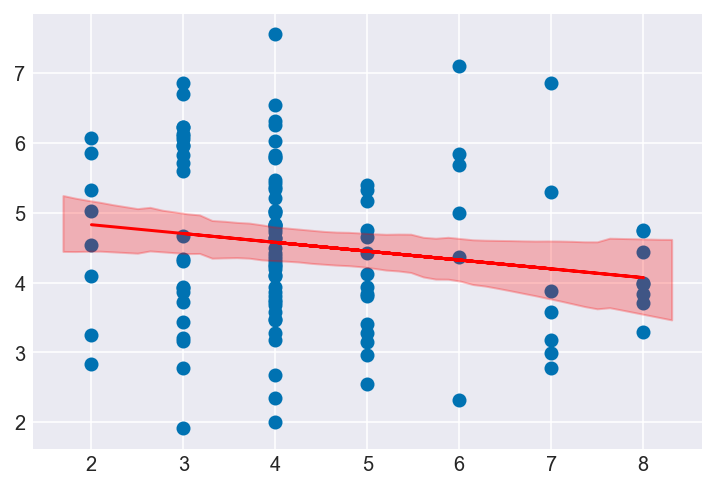

In [151]:
plt.scatter(df.groupsize, df.weight)
x = np.linspace(*plt.xlim())
y = trace.a.mean() + trace.b.mean() * df.groupsize
plt.plot(df.groupsize, y, c='r')
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

Neither variable seems that predictive of weight on its own, although groupsize has a slightly negative correlation with weight. 

### 5H2
Now fit a multiple linear regression with _weight_ as the outcome and both _area_ and _groupsize_ as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor constant as its mean. What does this model say about the importance of each variable? Why do you get different results than you got in the exercise above?

In [152]:
with pm.Model() as model:
    alpha = pm.Normal('a', 0, 10)
    beta = pm.Normal('b', 0, 10, shape=2)
    mu = alpha + beta[0] * df.area + beta[1] * df.groupsize
    
    sigma = pm.InverseGamma('sd', 1)
    w = pm.Normal('w', mu, sigma, observed=df.weight)
    trace = pm.sample(200, tune=1000)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, b, a]
Sampling 2 chains: 100%|██████████| 2400/2400 [00:08<00:00, 286.50draws/s]


In [153]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
a     4.444651  0.380921  0.021849  3.692200  5.182391  273.692908  1.005558
b__0  0.613882  0.199627  0.011929  0.207225  0.952781  219.738336  1.005998
b__1 -0.429265  0.123669  0.007404 -0.670885 -0.189678  242.488422  0.999254
sd    1.140236  0.071301  0.003672  1.014346  1.290977  306.712332  0.997773

#### Holding Area constant

In [163]:
x = np.linspace(min(df.groupsize), max(df.groupsize))
mu_pred = np.zeros((len(x), len(trace)*trace.nchains))
for i, g in enumerate(x):
    mu_pred[i] = trace.a + trace.b[:,0] * np.mean(df.area) + trace.b[:,1] * g
mu_hpd = pm.hpd(mu_pred.T)    

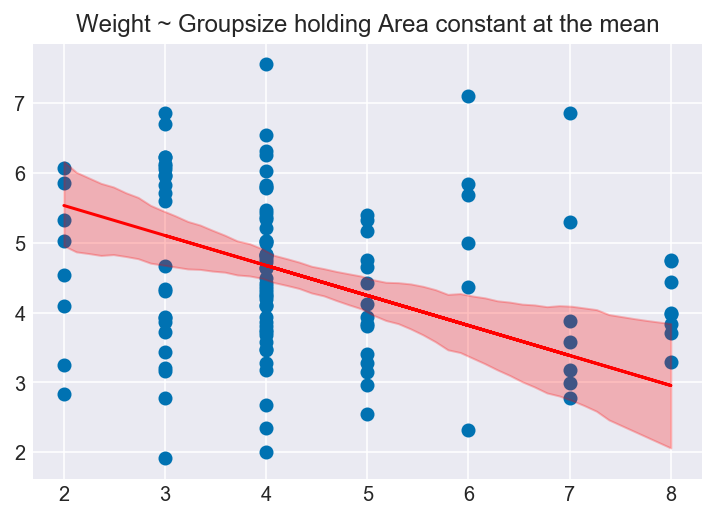

In [173]:
plt.scatter(df.groupsize, df.weight)
y = trace.a.mean() + trace.b[:,0].mean() * np.mean(df.area) + trace.b[:,1].mean() * df.groupsize
plt.plot(df.groupsize, y, c='r')
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.25)
plt.title('Weight ~ Groupsize holding Area constant at the mean');

I.e. Assuming a constant territorial area, the weight is negatively correlated with groupsize

#### Holding Groupsize Constant

In [177]:
x = np.linspace(min(df.area), max(df.area))
mu_pred = np.zeros((len(x), len(trace)*trace.nchains))
for i, a in enumerate(x):
    mu_pred[i] = trace.a + trace.b[:,0] * a + trace.b[:,1] * np.mean(df.groupsize)
mu_hpd = pm.hpd(mu_pred.T)    

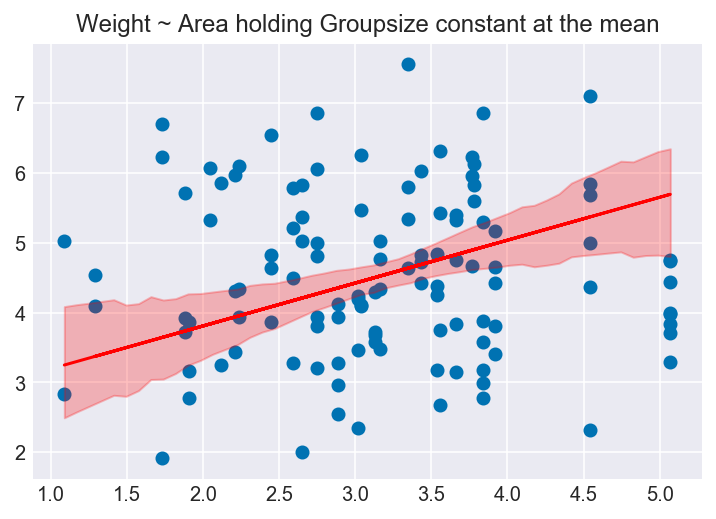

In [178]:
plt.scatter(df.area, df.weight)
y = trace.a.mean() + trace.b[:,0].mean() * df.area + trace.b[:,1].mean() * np.mean(df.groupsize)
plt.plot(df.area, y, c='r')
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.25)
plt.title('Weight ~ Area holding Groupsize constant at the mean');

Multivariate model states that both predictors are equally important. This relationship was likely hidden in the bivariate regressions due to a _masking_ relationship between the two predictors. That is, the outcome variable is correlated with both predictors but in opposite directions. 

### 5H3
Finally consider the _avgfood_ variable. Fit two more multiple regressions: (1) body weight as an additive function of _avgfood_ and _groupsize_ and (2) body weight as an additive function of all three variables, _avgfood_ and _groupsize_ and _area_. Compare the results of these models to the previous models you've fit, in the first two exercises. 
 
(a) is _avgfood_ or _area_ a beter predictor of body weight? If you had to choose one or the other to include in the model which would it be?

(b) When both _avgfood_ and _area_ are in the same model, their effects are reduced (closer to zero) and their standard errors are larger than when they are included in separate models. Can you explain this result?

#### Weight ~ AvgFood + Groupsize

Let's use the GLM module to save us some boilerplate and standardize all our predictors so they're comparable to their effect on the outcome variable.

In [195]:
df['avgfood_s'] = (df.avgfood - np.mean(df.avgfood)) / np.std(df.avgfood)
df['area_s'] = (df.area - np.mean(df.area)) / np.std(df.area)
df['groupsize_s'] = (df.groupsize - np.mean(df.groupsize)) / np.std(df.groupsize)
df.head(2)

group  avgfood  groupsize  area  weight  avgfood_s    area_s  groupsize_s
0      1     0.37          2  1.09    5.02   -1.93318 -2.249313    -1.530701
1      1     0.37          2  1.09    2.84   -1.93318 -2.249313    -1.530701

In [189]:
with pm.Model() as model:
    pm.GLM.from_formula('weight ~ avgfood_s + groupsize_s', data=df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, groupsize_s, avgfood_s, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 511.67draws/s]


In [190]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff  \
Intercept    4.534021  0.108936  0.003753  4.312106  4.737907  735.314589   
avgfood_s    0.750784  0.238949  0.009170  0.283156  1.192761  557.954749   
groupsize_s -0.859759  0.240216  0.009140 -1.285947 -0.347413  556.900260   
sd           1.145292  0.075898  0.002511  1.001052  1.279050  880.563022   

                 Rhat  
Intercept    0.999160  
avgfood_s    0.999001  
groupsize_s  0.999396  
sd           1.000831

#### Weight ~ AvgFood + Groupsize + Area

In [192]:
with pm.Model() as model:
    pm.GLM.from_formula('weight ~ avgfood_s + groupsize_s + area_s', data=df)
    trace = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, area_s, groupsize_s, avgfood_s, Intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 430.67draws/s]


In [193]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
Intercept    4.524534  0.107833  0.003470  4.329142  4.761753  1025.818192   
avgfood_s    0.493949  0.287362  0.012161 -0.043770  1.030641   494.929568   
groupsize_s -0.924691  0.254037  0.009871 -1.421078 -0.459736   577.699029   
area_s       0.348854  0.218998  0.008631 -0.046816  0.802543   545.009206   
sd           1.140281  0.077770  0.002473  0.994606  1.297442   799.011610   

                 Rhat  
Intercept    0.999053  
avgfood_s    1.000298  
groupsize_s  0.999119  
area_s       1.002915  
sd           0.999578

#### A
Both `avgfood` and `groupsize` have similar power in predicting the outcome, although `groupsize` is slightly "more" correlated.

#### B
When `area` and `avgfood` are in the same model, their effects are slightly reduced. This can be explained by `avgfood` and `area`'s _collinearity_ as demonstrated below

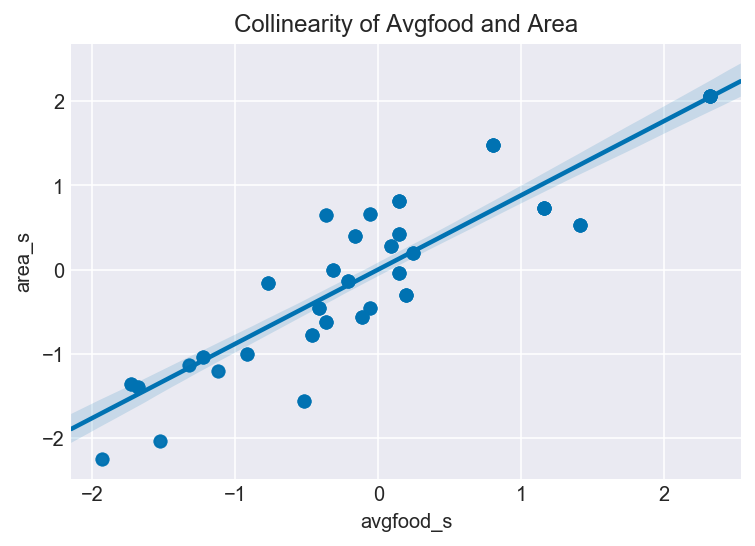

In [199]:
sns.regplot(df.avgfood_s, df.area_s);
plt.title('Collinearity of Avgfood and Area');